In [1]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset

In [2]:
class CernDatasetFullEvo(Dataset):
    def __init__(self, folder, evo_length=9, max_dataset_size=None, load_from_npy=False, load_velocities=False, modified_velocities=True):
        self.root_dir = folder
        self.evo_length = evo_length
        self.load_from_npy = load_from_npy
        self.load_velocities = load_velocities
        self.modified_velocities = modified_velocities
        self.paths = []

        broken_files = {
            'D:/CernDataset/447/jobresult_5/printing_VISHNew/results/snapshot_Ed.dat',
            'D:/CernDataset/802/jobresult_8/printing_VISHNew/results/snapshot_Ed.dat',
            'D:/CernDataset/985/jobresult_1/printing_VISHNew/results/snapshot_Ed.dat'
        }

        for idx in os.listdir(folder):
            for jobresult in os.listdir(f'{folder}/{idx}'):
                path = f'{folder}/{idx}/{jobresult}/printing_VISHNew/results/snapshot_Ed.dat'
                if (os.path.exists(path) and os.path.getsize(path) // 1048576 > evo_length + 1):
                    if path not in broken_files:
                        self.paths.append(f'{idx}/{jobresult}')

        if load_velocities:
            paths_t = []
            for path in self.paths:
                path_t = f'{folder}/{path}/printing_VISHNew/results'
                if (os.path.exists(f'{path_t}/vx.npy') and
                    os.path.exists(f'{path_t}/vy.npy') and
                    os.path.getsize(f'{path_t}/vx.npy') == 2452484 and 
                    os.path.getsize(f'{path_t}/vy.npy') == 2452484):
                    paths_t.append(path)
            self.paths = paths_t

        if max_dataset_size is not None:
            self.paths = self.paths[:max_dataset_size]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        sample_name = self.paths[index]
        sample_path = os.path.join(self.root_dir, sample_name)

        img = np.array([], dtype=np.float32)
        y = np.array([], dtype=np.float32)

        if self.load_from_npy:
            y = np.load(f'{sample_path}/printing_VISHNew/results/y.npy')
            img = np.load(f'{sample_path}/printing_VISHNew/results/img.npy')
        else:
            with open(f'{sample_path}/printing_VISHNew/results/snapshot_Ed.dat') as f:
                for idx, line in enumerate(f):
                    if idx > 262 and idx < 262 * 2:
                        t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                        img = np.hstack((img, t))
                    if idx > 262 * 2 and idx < 262 * (self.evo_length + 2) and (idx % 262 != 0):
                        t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                        y = np.hstack((y, t))

        if self.load_velocities:
            vxs = np.load(f'{sample_path}/printing_VISHNew/results/vx.npy')
            vys = np.load(f'{sample_path}/printing_VISHNew/results/vy.npy')
            y = np.concatenate((y, vxs))
            y = np.concatenate((y, vys))

        y_t = torch.from_numpy(y.reshape((-1, 261, 261)))
        img_t = torch.from_numpy(img.reshape((1, 261, 261)))

        if self.modified_velocities:
            y_t[9:18] *= y_t[:9]
            y_t[18:27] *= y_t[:9]
        y_t = y_t[:, 3:-2, 3:-2]
        img_t = img_t[:, 3:-2, 3:-2]

        return img_t, y_t

    def generate_npys(self):
        """Generates img.npy and y.npy for each training sample for faster load."""
        num_paths = len(self.paths)
        for i, path in enumerate(self.paths):
            sample_path = os.path.join(self.root_dir, path)

            img = np.array([], dtype=np.float32)
            y = np.array([], dtype=np.float32)

            with open(f'{sample_path}/printing_VISHNew/results/snapshot_Ed.dat') as f:
                for idx, line in enumerate(f):
                    if idx > 262 and idx < 262 * 2:
                        t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                        img = np.hstack((img, t))
                    if idx > 262 * 2 and idx < 262 * (self.evo_length + 2) and (idx % 262 != 0):
                        t = np.fromstring(" ".join(line.split()), sep = ' ', dtype=np.float32)
                        y = np.hstack((y, t))

            np.save(f'{sample_path}/printing_VISHNew/results/y.npy',  y)
            np.save(f'{sample_path}/printing_VISHNew/results/img.npy',  img)

            print(f'{i+1}/{num_paths} generated')


In [3]:
train_folder = 'C:/Users/Николай/Desktop/CernProject/data'

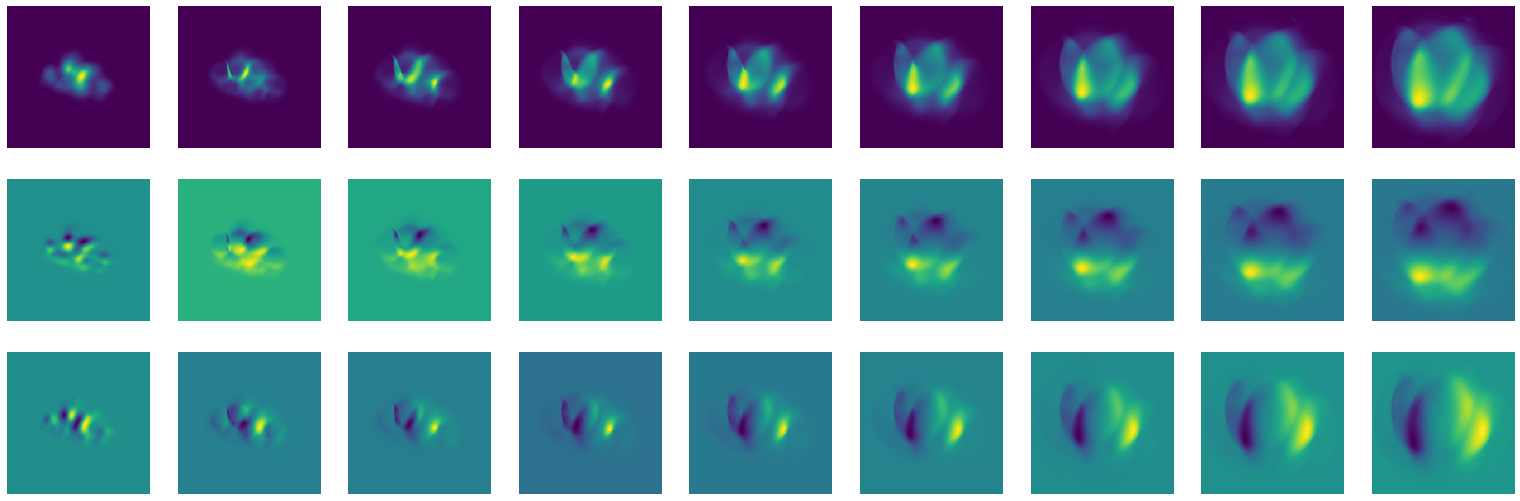

In [4]:
dataset = CernDatasetFullEvo(train_folder, load_from_npy=True, 
                                      load_velocities=True,
                                      modified_velocities=True)
            
x, y = dataset[3]
plt.figure(figsize=(9*3, 3*3))
for i in range(9):
    plt.subplot(3, 9, i + 1)
    plt.imshow(y[i])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, 9, i + 10)
    plt.imshow(y[i + 9])
    plt.grid(False)
    plt.axis('off')
    plt.subplot(3, 9, i + 19)
    plt.imshow(y[i + 18])
    plt.grid(False)
    plt.axis('off')

In [5]:
y.shape

torch.Size([27, 256, 256])

In [6]:
def plot_ev(evolution, t_freeze=0.18, eps=0.01):
    Ed, Vx, Vy = evolution
    fig = plt.figure(figsize=(30,9))
    for i in range(len(Ed)):
        fig.add_subplot(3, len(Ed), i + 1)
        plt.imshow(Ed[i], alpha=0.9)
        plt.imshow(np.abs(Ed[i]- t_freeze) < eps, alpha=0.1)
        fig.add_subplot(3, len(Ed), i + len(Ed) + 1)
        plt.imshow(Vx[i], alpha=0.9)
        fig.add_subplot(3, len(Ed), i + 2 * len(Ed) + 1)
        plt.imshow(Vy[i], alpha=0.9)

In [7]:
path_to_models = 'models'

def predict(x, threshold=0.005):
    Ed = np.array((x))
    Vx = np.array((np.zeros_like(x)))
    Vy = np.array((np.zeros_like(x)))
    x = torch.from_numpy(x)
    x = torch.unsqueeze(torch.unsqueeze(x, 0), 0)

    for t in range(9):
        model = torch.load(f'{path_to_models}/u{t}{t+1}.pth')
        model.eval()

        x = model(x) 
        prediction = x.detach().numpy() 

        Ed = np.append(Ed, prediction[0, 0])
        Vx = np.append(Vx, prediction[0, 1])
        Vy = np.append(Vy, prediction[0, 2])

    return Ed.reshape((-1, 256, 256)), Vx.reshape((-1, 256, 256)), Vy.reshape((-1, 256, 256))

In [8]:
%%time
ev = predict(torch.squeeze(x).numpy())

Wall time: 7.28 s


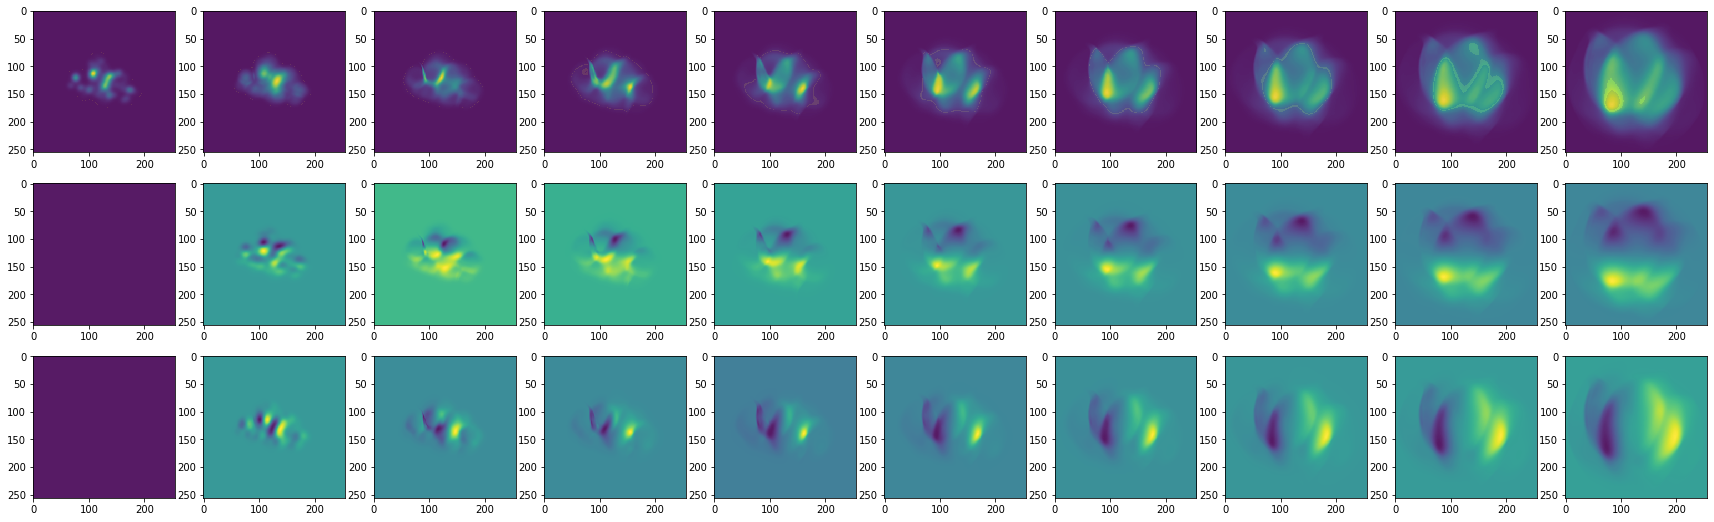

In [9]:
plot_ev(ev)

In [15]:
def rectify(ev):
    return torch.from_numpy(np.asarray(ev)[:, 1:, :, :].reshape(27, 256, 256))

In [10]:
prediction = torch.from_numpy(np.asarray(ev)[:, 1:, :, :].reshape(27, 256, 256))

In [11]:
def unet_loss(output, target):
    loss = 0.5 * torch.sum(torch.abs(output - target)) / torch.sum(torch.abs(target))
    return loss

def loss(x, y):
    loss = 0
    for i in range(27):
        loss += unet_loss(x[i], y[i])
    return loss

In [27]:
loss(prediction[8], y[8])

tensor(92.2807)

In [13]:
loss(prediction, y)

tensor(0.1367)

# Посмотрим на суммарную потерю на других входных данных

In [16]:
def plot_y(y):
    plt.figure(figsize=(9*3, 3*3))
    for i in range(9):
        plt.subplot(3, 9, i + 1)
        plt.imshow(y[i])
        plt.grid(False)
        plt.axis('off')
        plt.subplot(3, 9, i + 10)
        plt.imshow(y[i + 9])
        plt.grid(False)
        plt.axis('off')
        plt.subplot(3, 9, i + 19)
        plt.imshow(y[i + 18])
        plt.grid(False)
        plt.axis('off')

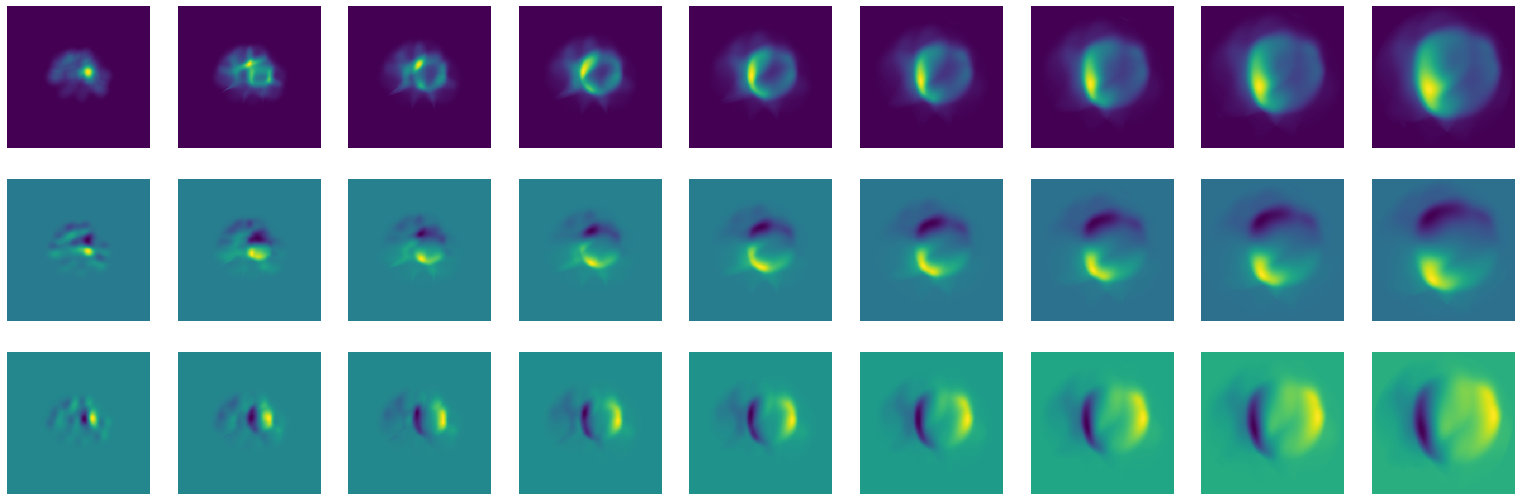

In [18]:
x, y = dataset[13]
plot_y(y)

In [29]:
x = torch.zeros_like(x)
x[100:-100, 100:-100] = 0.5

In [30]:
ev = predict(torch.squeeze(x).numpy())

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [20]:
loss(rectify(ev), y)

tensor(0.1053)

In [21]:
def calc_summ_error(index):
    x, y = dataset[index]
    ev = predict(torch.squeeze(x).numpy())
    return loss(rectify(ev), y)

In [22]:
calc_summ_error(17)

tensor(0.1086)

In [23]:
calc_summ_error(173)

tensor(0.0806)

# Действительно ли новые модели лучше?

In [24]:
path_to_models = 'D:/models'

In [25]:
calc_summ_error(17)

tensor(0.4507)

In [26]:
calc_summ_error(173)

tensor(0.3996)